# Apartat A

In [ ]:
import ast

import pandas as pd
import numpy as np

from sklearn import linear_model, svm, datasets, neighbors, tree, naive_bayes
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

import scipy

import matplotlib.pyplot as plt

import seaborn as sns

**name**: The English name of the Pokemon\
**japanese_name**: The Original Japanese name of the Pokemon\
**pokedex_number**: The entry number of the Pokemon in the National Pokedex\
**percentage_male**: The percentage of the species that are male. Blank if the Pokemon is genderless.\
**type1**: The Primary Type of the Pokemon\
**type2**: The Secondary Type of the Pokemon\
**classification**: The Classification of the Pokemon as described by the Sun and Moon Pokedex\
**height_m**: Height of the Pokemon in metres\
**weight_kg**: The Weight of the Pokemon in kilograms\
**capture_rate**: Capture Rate of the Pokemon\
**baseeggsteps**: The number of steps required to hatch an egg of the Pokemon\
**abilities**: A stringified list of abilities that the Pokemon is capable of having\
**experience_growth**: The Experience Growth of the Pokemon\
**base_happiness**: Base Happiness of the Pokemon\
**against_?**: Eighteen features that denote the amount of damage taken against an attack of a particular type\
**hp**: The Base HP of the Pokemon\
**attack**: The Base Attack of the Pokemon\
**defense**: The Base Defense of the Pokemon\
**sp_attack**: The Base Special Attack of the Pokemon\
**sp_defense**: The Base Special Defense of the Pokemon\
**speed**: The Base Speed of the Pokemon\
**generation**: The numbered generation which the Pokemon was first introduced\
**is_legendary**: Denotes if the Pokemon is legendary.

In [ ]:
df = pd.read_csv('pokemon.csv')

In [ ]:
TARGET = 'is_legendary'
FILTER_RATE = 0.1
NAMES = df['name']

### APARTAT A

**EXPLORATORY DATA ANALYSIS**

**Quants atributs té la vostra base de dades?**

In [ ]:
len(df.columns)

41

**Quins tipus d'atributs tens?**

Categòrics, decimals i enters.

In [ ]:
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

**Com és el *target*, quantes categories diferents existeixen?**

El *target* és un atribut binari.

In [ ]:
df[TARGET].unique()

array([0, 1])

**Podeu veure alguna correlació entre X i y?**

Hi ha atributs amb molta correlació amb el *target* i d'altres que no gaire.

In [ ]:
df.corr()[TARGET].abs().sort_values(ascending=False)

is_legendary         1.000000
base_egg_steps       0.873488
base_total           0.485440
base_happiness       0.413108
sp_attack            0.406281
weight_kg            0.393023
experience_growth    0.361038
sp_defense           0.343241
height_m             0.322155
speed                0.311639
hp                   0.308405
attack               0.303295
defense              0.265587
pokedex_number       0.196785
against_ghost        0.170746
generation           0.139029
against_dark         0.136315
against_psychic      0.106047
against_grass        0.070826
against_flying       0.062214
against_fight        0.059132
against_fairy        0.050165
percentage_male      0.045222
against_normal       0.034761
against_bug          0.027864
against_poison       0.024349
against_electric     0.023151
against_water        0.020679
against_rock         0.017588
against_dragon       0.014844
against_ground       0.012812
against_fire         0.011073
against_ice          0.005580
against_st

**Estan balancejades les etiquetes?**

Hi ha molts més *samples* de Pokemon comuns que de legendaris.

In [ ]:
df[TARGET].value_counts()

0    731
1     70
Name: is_legendary, dtype: int64

**PREPROCESSING**

**Estan les dades normalitzades? Caldria fer-ho?**

Les dades no estan normalitzades. Caldria escalarles ja que els atributs numèrics tenen escales molt variades.

In [ ]:
for col in df.select_dtypes(exclude='object'):
    stat, pvalue = scipy.stats.normaltest(df[col])
    if pvalue > 1e-3:
        print(col)

**Com controleu les dades sense informació (NaNs)?**

Als atributs de tipus numèric, substituirem els valors NaN per la mitja de l'atribut. Els valors NaN dels atributs categòrics desapareixeran quan fem el `OneHotEncoding`.

In [ ]:
df.isnull().sum()[df.isnull().sum() > 0]

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

In [ ]:
df_raw = df.copy(deep=True)
df = df.fillna(df.mean())

In [ ]:
# 2. Preprocessing
#No estàn normalitzades, 
#No té sentit intentar normalitzar ja que la majoria de dades que tenim són binàries
#No tenim gaires nan's excepte en el type2, no podem reomplir-les degut a que són strings
# (faltar contestar mes coses aqui...) Canvis dataset: En la columna capture_rate hi ha un valor que és de tipus object que no té sentit, hem ficat el valor de 70 al buscar el capture rate del pokemon a internet
# Tenim algunes variables categòriques com: classification, type1, type2, name i japanese_name, abilities (lista)
#

In [ ]:
df.at[df['name'] == 'Minior', 'capture_rate'] = 70  # Because '30 (Meteorite)255 (Core)'
df['capture_rate'] = df['capture_rate'].astype('int64')

In [ ]:
df.describe().loc[['mean', '50%', 'std']]

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,height_m,hp,percentage_male,pokedex_number,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.163892,68.958801,55.155761,401.000000,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,65.000000,50.000000,401.000000,65.000000,66.000000,65.000000,28.500000,4.000000,0.000000
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.066737,26.576015,18.980069,231.373075,32.353826,27.942501,28.907662,107.979179,1.930420,0.282583


In [ ]:
# Gaussian if (mediana y media similar y desv.std entre el 20 y 30% de la media)
desc = df.describe().loc[['mean', '50%', 'std']]

In [ ]:
#atributs que no es poden normalitzar: generation, is_legendary, els que són objectes

**Com codifiqueu les dades categòriques? (OrdinalEncoder, OneHotEncoder)**

In [ ]:
df_2 = df.copy(deep=True)
df_2['abilities'] = df['abilities'].apply(ast.literal_eval)
df_2[df_2['abilities'].explode().unique()] = 0

for idx, row in df_2.iterrows():
    for cat in row['abilities']:
        df_2.at[idx, cat] = 1

df_2.drop(columns='abilities', inplace=True)
df_2 = pd.get_dummies(df_2, columns=['classfication', 'type1', 'type2'], prefix=['', '1', '2'], prefix_sep='')
df_2.drop(columns=['name', 'japanese_name'], inplace=True)

**Quin tipus de normalització serà més adient per les vostres dades?**

In [ ]:
cols = df_2.columns
scaler = MinMaxScaler()
df_3=scaler.fit_transform(df_2) #dataset escalat
df_3 = pd.DataFrame(df_3,
columns=cols)

In [ ]:
corr = df_3.corr().abs()[TARGET].sort_values(ascending=False)
corr = corr[corr > FILTER_RATE]
#corr
df_4=df_3[corr.index]
df_4 #dataset amb atributs filtrats per correlacio
# corr.index
# df_4.columns[df_4.columns.duplicated()]
# corr.index.unique()


,is_legendary,base_egg_steps,base_total,base_happiness,sp_attack,weight_kg,experience_growth,sp_defense,capture_rate,height_m,...,Paleozoic Pokémon,Cyclone Pokémon,Deep Black Pokémon,Iron Will Pokémon,Cavern Pokémon,Grassland Pokémon,1dragon,against_psychic,1steel,Clear Body
0,0.0,0.130435,0.230000,0.5,0.298913,0.006801,0.442173,0.214286,0.166667,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
1,0.0,0.130435,0.375000,0.5,0.380435,0.012903,0.442173,0.285714,0.166667,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
2,0.0,0.130435,0.741667,0.5,0.608696,0.099920,0.442173,0.476190,0.166667,0.131944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
3,0.0,0.130435,0.215000,0.5,0.271739,0.008402,0.442173,0.142857,0.166667,0.034722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0
4,0.0,0.130435,0.375000,0.5,0.380435,0.018904,0.442173,0.214286,0.166667,0.069444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1.0,1.000000,0.650000,0.0,0.527174,1.000000,0.625000,0.385714,0.087302,0.631944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,1.0,0.0
797,1.0,1.000000,0.650000,0.0,0.266304,0.000000,0.625000,0.052381,1.000000,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0
798,1.0,1.000000,0.650000,0.0,0.472826,0.888078,0.625000,0.157143,0.047619,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
799,1.0,1.000000,0.700000,0.0,0.635870,0.229946,0.625000,0.328571,0.000000,0.159722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0


In [ ]:
df_4.isnull().sum()[df_4.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
import random

idx_nolegendary = random.sample(list(df_4[df_4[TARGET] == 0].index), 731-70)
df_5 = df_4.drop(index=idx_nolegendary)
df_5.reset_index(inplace=True, drop=True)
df_5

,is_legendary,base_egg_steps,base_total,base_happiness,sp_attack,weight_kg,experience_growth,sp_defense,capture_rate,height_m,...,Paleozoic Pokémon,Cyclone Pokémon,Deep Black Pokémon,Iron Will Pokémon,Cavern Pokémon,Grassland Pokémon,1dragon,against_psychic,1steel,Clear Body
0,0.0,0.130435,0.750000,0.5,0.679348,0.085417,0.442173,0.452381,0.166667,0.104167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0
1,0.0,0.086957,0.025000,0.5,0.054348,0.003101,0.384615,0.000000,1.000000,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
2,0.0,0.130435,0.541667,0.5,0.353261,0.059912,0.442173,0.309524,0.166667,0.083333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
3,0.0,0.130435,0.183333,0.5,0.217391,0.061290,0.384615,0.095238,1.000000,0.073881,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250,0.0,0.0
4,0.0,0.130435,0.458333,0.5,0.271739,0.031906,0.384615,0.238095,0.285714,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.0,1.000000,0.650000,0.0,0.527174,1.000000,0.625000,0.385714,0.087302,0.631944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,1.0,0.0
136,1.0,1.000000,0.650000,0.0,0.266304,0.000000,0.625000,0.052381,1.000000,0.013889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0
137,1.0,1.000000,0.650000,0.0,0.472826,0.888078,0.625000,0.157143,0.047619,0.375000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
138,1.0,1.000000,0.700000,0.0,0.635870,0.229946,0.625000,0.328571,0.000000,0.159722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0


**Caldra aplicar un PCA?**

**Es poden aplicar `PolynomialFeatures` per millorar la classificació?**

No perquè hi ha massa atributs. Els `PolynomialFeatures` aumenten exponencial.

**MODEL SELECTION**

**Quins models heu considerat?**

In [ ]:
from sklearn.metrics import confusion_matrix
X=df_4.copy(deep=True)
X.drop(columns=TARGET, inplace=True)
y=df_4[TARGET]

X2=df_5.copy(deep=True)
X2.drop(columns=TARGET, inplace=True)
y2=df_5[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)


classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    'SVCpoly': svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB()
}

scores = {}
scores2 = {}
mean2 = 0
ITERACIONS=10

score_ls = {name: [] for name in classifiers}
scores_ls2 = {name: [] for name in classifiers}


for _ in range(ITERACIONS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        score = classifier.score(X_test, y_test)
        score_ls[name].append(score)

scores = {name: sum(score)/len(score) for name, score in score_ls.items()}

for seed in range(ITERACIONS):
     X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)
     for name, classifier in classifiers.items():
         classifier.fit(X2_train, y2_train)
         y_pred = classifier.predict(X2_test)
         score = classifier.score(X2_test, y2_test)
         scores_ls2[name].append(score)

scores2 = {name: sum(score)/len(score) for name, score in scores_ls2.items()}

print("Con df_4")
print(scores)

print("\n")
print("Con df_5")
print(scores2)


Con df_4
{'LogisticRegression': 0.9826086956521738, 'SVC': 0.9900621118012423, 'LinearSVC': 0.9863354037267081, 'SVCrbf': 0.9900621118012423, 'SVCpoly': 0.8993788819875776, 'SGDClassifier': 0.9639751552795032, 'KNeighborsClassifier': 0.9037267080745341, 'DecisionTreeClassifier': 0.9931677018633541, 'GaussianNB': 0.9198757763975152}


Con df_5
{'LogisticRegression': 0.9785714285714286, 'SVC': 0.975, 'LinearSVC': 0.9785714285714286, 'SVCrbf': 0.9964285714285716, 'SVCpoly': 0.4392857142857142, 'SGDClassifier': 0.975, 'KNeighborsClassifier': 0.6428571428571429, 'DecisionTreeClassifier': 0.9428571428571428, 'GaussianNB': 0.7714285714285714}


In [ ]:
from sklearn.metrics import confusion_matrix
X=df_4.copy(deep=True)
X.drop(columns=TARGET, inplace=True)
y=df_4[TARGET]

X2=df_5.copy(deep=True)
X2.drop(columns=TARGET, inplace=True)
y2=df_5[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)


scores = {}
scores2 = {}
mean2 = 0
ITERACIONS=10

confusion_matrices = {name: [] for name in classifiers}
confusion_matrices2 = {name: [] for name in classifiers}


for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    confusion_matrices[name]=confusion_matrix(y_test,y_pred).ravel()


for name, classifier in classifiers.items():
    classifier.fit(X2_train, y2_train)
    y2_pred = classifier.predict(X2_test)
    confusion_matrices2[name]=confusion_matrix(y2_test,y2_pred).ravel()


print("Con df_4")
print("tn, fp, fn, tp")
print(confusion_matrices)

print("\n")
print("Con df_5")
print("tn, fp, fn, tp")
print(confusion_matrices2)


Con df_4
tn, fp, fn, tp
{'LogisticRegression': array([149,   0,   0,  12]), 'SVC': array([149,   0,   0,  12]), 'LinearSVC': array([149,   0,   0,  12]), 'SVCrbf': array([149,   0,   0,  12]), 'SVCpoly': array([149,   0,  12,   0]), 'SGDClassifier': array([149,   0,   3,   9]), 'KNeighborsClassifier': array([149,   0,  10,   2]), 'DecisionTreeClassifier': array([149,   0,   0,  12]), 'GaussianNB': array([149,   0,  10,   2])}


Con df_5
tn, fp, fn, tp
{'LogisticRegression': array([12,  0,  1, 15]), 'SVC': array([12,  0,  1, 15]), 'LinearSVC': array([12,  0,  1, 15]), 'SVCrbf': array([12,  0,  0, 16]), 'SVCpoly': array([12,  0, 16,  0]), 'SGDClassifier': array([12,  0,  1, 15]), 'KNeighborsClassifier': array([12,  0, 13,  3]), 'DecisionTreeClassifier': array([12,  0,  0, 16]), 'GaussianNB': array([12,  0,  5, 11])}


In [ ]:
# len(classifiers[0].coef_)

In [ ]:

results=[]
for classifier in classifiers:
    # print(classifier.__class__.__name__)
    try:
        results.append(dict(zip(X.columns, classifier.coef_[0])))
    except:
        pass
len(results)

0

In [ ]:
# coeficients = dict.fromkeys(X.columns, [])

coeficients = {col: [] for col in X.columns}

for classifier in classifiers:
    try:
        for col, coef in zip(coeficients, classifier.coef_[0]):
            coeficients[col].append(coef)
    except:
        pass

coeficients

# len(classifiers)

{'base_egg_steps': [],
 'base_total': [],
 'base_happiness': [],
 'sp_attack': [],
 'weight_kg': [],
 'experience_growth': [],
 'sp_defense': [],
 'capture_rate': [],
 'height_m': [],
 'speed': [],
 'hp': [],
 'Beast Boost': [],
 'attack': [],
 'Pressure': [],
 'defense': [],
 'Land Spirit Pokémon': [],
 '1psychic': [],
 'pokedex_number': [],
 'against_ghost': [],
 'Eon Pokémon': [],
 'Turboblaze': [],
 'Teravolt': [],
 'Telepathy': [],
 'generation': [],
 'against_dark': [],
 'Justified': [],
 'Sea Basin Pokémon': [],
 'Air Lock': [],
 'DNA Pokémon': [],
 'New Species Pokémon': [],
 'Sky High Pokémon': [],
 'Wish Pokémon': [],
 'Iron Pokémon': [],
 'Rock Peak Pokémon': [],
 'Knowledge Pokémon': [],
 'Genetic Pokémon': [],
 'Freeze Pokémon': [],
 'Bad Dreams': [],
 'Pitch-Black Pokémon': [],
 'Order Pokémon': [],
 'Colossal Pokémon': [],
 'Aura Break': [],
 'Slow Start': [],
 'Mischief Pokémon (Confined)Djinn Pokémonn (Unbound)': [],
 'Power Construct': [],
 'Prism Armor': [],
 'Steam 

**Considereu les SVM amb els diferents *kernels* implementats.**

**Quin creieu que serà el més precís?**

**Quin serà el més ràpid?**

El model més ràpid

**Seria una bona idea fer un `ensemble`? Quins inconvenients creieu que pot haver-hi?**

In [ ]:
#Provem alguns classificadors d'ensemble amb el dataset que té més dades, el no distribuït equitativament
rnd_F = RandomForestClassifier(n_estimators=10)
rnd_F = rnd_F.fit(X_train, y_train)
y_pred = rnd_F.predict(X_test)
score = rnd_F.score(X_test, y_test)
print(f'{rnd_F.__class__.__name__}: {score}')


RandomForestClassifier: 1.0


In [ ]:
bagging = BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5)
bagging=bagging.fit(X_train,y_train)
y_pred = bagging.predict(X_test)
score = bagging.score(X_test, y_test)
print(f'{bagging.__class__.__name__}: {score}')

BaggingClassifier: 0.9751552795031055


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
boosting = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
score=boosting.score(X_test, y_test)
print(f'{boosting.__class__.__name__}: {score}')

GradientBoostingClassifier: 0.9875776397515528


La tasca d'aquesta pràctica s'enmarca dins l'aprenentatge computacional supervisat. A sklearn, disposem de varies tècniques (veure documentació). A les classes de teoria, hem vist varies tècniques, com ara logistic regression, SVM amb diferents kernels, Nearest Neighbour, i el perceptró... En aquesta secció heu de valorar quina o quines tècniques voleu fer servir, aixi com també explicar el per què les heu seleccionat. Recomanem, que per entendre millor la teoria, s'ha de provar com a mínim un model de SVM.

**CROSSVALIDATION**

**Per què és important cross-validar els resultats?**

Per evitar que una partició concreta del *dataset* aporti un *bias* a les mètriques de validació.

**Separa la base de dades en el conjunt de train-test. Com de fiables serán els resultats obtinguts? En quins casos serà més fiable, si tenim moltes dades d'entrenament o poques?**

Serà més fiable quan tinguem moltes dades d'entrenament.

**Quin tipus de K-fold heu escollit? Quants conjunts heu seleccionat (quina k)? Com afecta els diferents valors de k?**

Utilitzant el Stratified method. Els plecs es fan conservant el percentatge de mostres per a cada classe. Els valors de la k faràn que canvi el número de plecs que es fa en el nostre dataset. Com que no tenim tantes dades hem de posar un número petit per tal de que no falli. Hem escollit un valor de k: 5.

**Es viable o convenient aplicar LeaveOneOut?**

Si es fa servir una unica observació per calcular el error, aquest variarar molt segons quina observació es fagi servir. Per evitar-ho, el procés s'ha de repetir tants cops com observacions tenim i a cada iteració deixem fora una iteració diferent, ajustant el model amb la resta i calculant l'error. Al final farem la mitja de tots els errors. Aquest procés permet reduir la variabilitat quan dividim aleatoriament les observacions en dos grups. Per tant, els resultats obtinguts en principi seran més exactes però té un cost computacional molt més alt.

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn

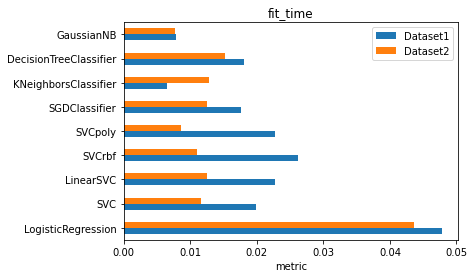

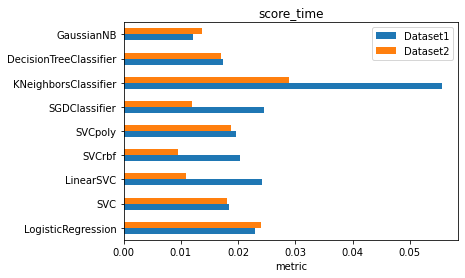

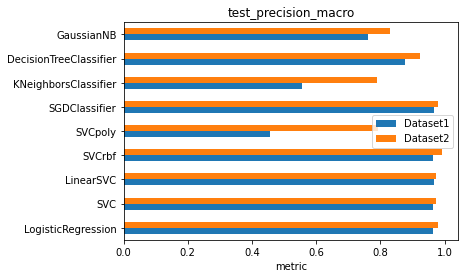

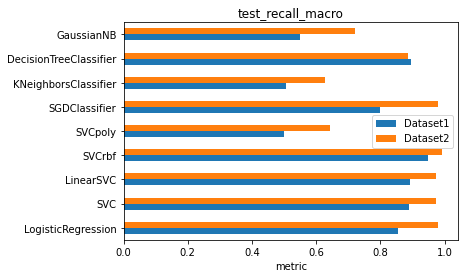

In [ ]:
X=df_4.copy(deep=True)
X.drop(columns=TARGET, inplace=True)
y=df_4[TARGET]

X2=df_5.copy(deep=True)
X2.drop(columns=TARGET, inplace=True)
y2=df_5[TARGET]

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    'SVCpoly': svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier(),
    'GaussianNB': naive_bayes.GaussianNB()
}


scoring = ['precision_macro', 'recall_macro']
dic = {}
dic2 = {}

for name, clf in classifiers.items():
    scores = cross_validate(clf, X, y, scoring=scoring, cv=5)
    dic[name]=scores

for name, clf in classifiers.items():
    scores = cross_validate(clf, X2, y2, scoring=scoring, cv=5)
    dic2[name]=scores

for clf_name in dic:
    dic[clf_name] = {metric: data.mean() for metric, data in dic[clf_name].items()}
#dic

for clf_name in dic:
    dic2[clf_name] = {metric: data.mean() for metric, data in dic2[clf_name].items()}

data = np.array([[value for value in metrics.values()] for metrics in dic.values()])
data2 = np.array([[value for value in metrics.values()] for metrics in dic2.values()])


for i, metric in enumerate(['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']):
    pd.DataFrame(
        np.array([data[:, i], data2[:, i]]).transpose(),
        columns=['Dataset1', 'Dataset2'],
        index=classifiers.keys()
    ).plot.barh()
    plt.title(metric)
    plt.xlabel('metric')

In [ ]:
#LeaveOneOut
from sklearn.model_selection import LeaveOneOut
X=df_4.copy(deep=True)
X.drop(columns=TARGET, inplace=True)
y=df_4[TARGET]

X2=df_5.copy(deep=True)
X2.drop(columns=TARGET, inplace=True)
y2=df_5[TARGET]
loo = LeaveOneOut()

#Com té un cost computacional molt alt, ja eliminem els classificadors que sabem que van pitjor
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'SVC': svm.SVC(kernel='linear', C=1.0),
    'LinearSVC': svm.LinearSVC(C=1.0, max_iter=1000000),
    'SVCrbf': svm.SVC(kernel='rbf', gamma=0.7, C=1.0),
    #'SVCpoly': svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0),
    'SGDClassifier': linear_model.SGDClassifier(loss="modified_huber", alpha=0.1),
    #'KNeighborsClassifier': neighbors.KNeighborsClassifier(n_neighbors=15),
    'DecisionTreeClassifier': tree.DecisionTreeClassifier()
    #'GaussianNB': naive_bayes.GaussianNB()
}

scores_ls = {name: [] for name in classifiers}
scores_ls2 = {name: [] for name in classifiers}

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        score = classifier.score(X_test, y_test)
        scores_ls[name].append(score)

scores = {name: sum(score)/len(score) for name, score in scores_ls.items()}

for train_index, test_index in loo.split(X2):
    X2_train, X2_test = X2.iloc[train_index], X2.iloc[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]
    for name, classifier in classifiers.items():
        classifier.fit(X2_train, y2_train)
        y_pred = classifier.predict(X2_test)
        score = classifier.score(X2_test, y2_test)
        scores_ls2[name].append(score)

scores2 = {name: sum(score)/len(score) for name, score in scores_ls2.items()}

print(scores)
print("\n")
print(scores2)

{'LogisticRegression': 0.9862671660424469, 'SVC': 0.9925093632958801, 'LinearSVC': 0.9912609238451935, 'SVCrbf': 0.9900124843945068, 'SGDClassifier': 0.9650436953807741, 'DecisionTreeClassifier': 0.9950062421972534}


{'LogisticRegression': 0.9785714285714285, 'SVC': 0.9857142857142858, 'LinearSVC': 0.9857142857142858, 'SVCrbf': 1.0, 'SGDClassifier': 0.9785714285714285, 'DecisionTreeClassifier': 0.9571428571428572}


**METRIC ANALYSIS**

**A teoria, hem vist el resultat d'aplicar el `accuracy_score` sobre dades no balancejades. Podrieu explicar i justificar quina de les següents mètriques será la més adient pel vostre problema? `accuracy_score`, `f1_score` o `average_precision_score`.**

Hauriem d'utilitzar el `average_precision_score`degut a que el nostre atribut objectiu és binari (La nostra classificació és binària). Els altres dos s'utilitzen en els casos en que ens trobem amb multiclasses.

**Mostreu la Precisió-Recall Curve i la ROC Curve. Quina és més rellevant pel vostre dataset? Expliqueu amb les vostres paraules, la diferencia entre una i altre**

Pel nostre dataset seria més interessant utilitzar el Precisió-Recall Curve degut a que tenim molt poc balancejades les dades del nostre atribut objectiu. Tot i així, com que tenim un dataset modificat equilibrat podem fer servir el ROC Curve.

Logistic: f1=0.933 auc=1.000


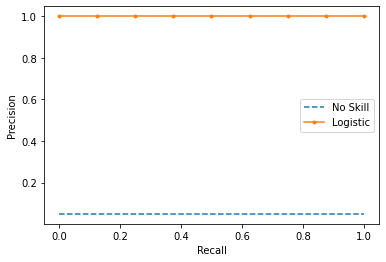

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

cls = LogisticRegression(solver='lbfgs')
cls.fit(X_train, y_train)
yhat = cls.predict(X_test)
lr_probs = cls.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.996


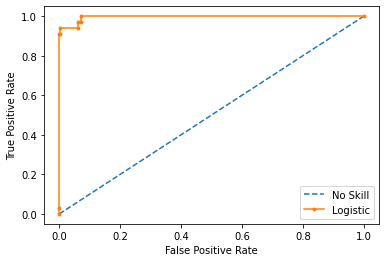

In [ ]:
#roc per a dades imbalanced
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
cls = LogisticRegression(solver='lbfgs')
cls.fit(X_train, y_train)
# predict probabilities
lr_probs = cls.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.993


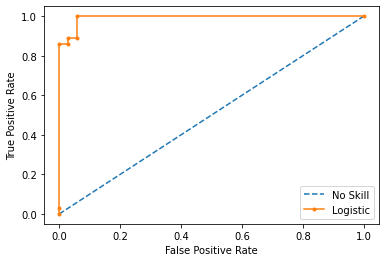

In [ ]:
# roc curve and auc
X = df_5.drop(columns=TARGET)
y = df_5[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
cls = LogisticRegression(solver='lbfgs')
cls.fit(X_train, y_train)
# predict probabilities
lr_probs = cls.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
particions = [0.5, 0.7, 0.8]
X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

for part in particions:
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    #Creem el regresor logístic
    svc = svm.SVC(C=10.0, kernel='linear', gamma=0.9, probability=True)

    # l'entrenem 
    svc.fit(x_t, y_t)
    probs = svc.predict_proba(x_v)
    print ("Correct classification SVM      ", part, "% of the data: ", svc.score(x_v, y_v))

Correct classification SVM       0.5 % of the data:  0.970074812967581
Correct classification SVM       0.7 % of the data:  0.983402489626556
Correct classification SVM       0.8 % of the data:  0.9627329192546584


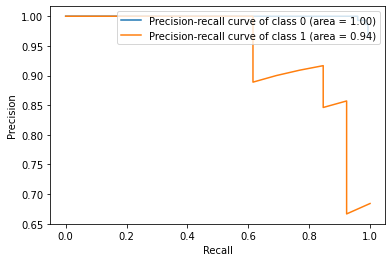

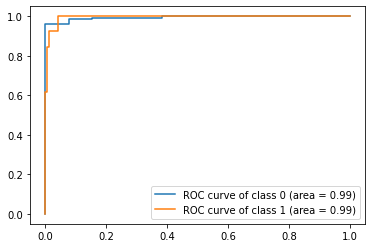

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, average_precision_score, roc_curve, auc

# Compute Precision-Recall and plot curve
precision = {}
recall = {}
average_precision = {}
plt.figure()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
    average_precision[i] = average_precision_score(y_v == i, probs[:, i])

    plt.plot(recall[i], precision[i],
    label='Precision-recall curve of class {0} (area = {1:0.2f})'
                           ''.format(i, average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="upper right")

    
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# Plot ROC curve
plt.figure()
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.legend()

**Què mostra la funció `classification_report()`? Quina métrica us fixareu per tal de optimitzar-ne la classificació pel vostre cas?**

In [ ]:
X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf_report = classification_report(
    y_test,
    y_pred,
    labels=[0, 1],
    target_names=['common', 'legendary'],
    output_dict=True
)

clf_report
pd.DataFrame(clf_report).drop(columns='accuracy')

,common,legendary,macro avg,weighted avg
precision,0.979592,0.928571,0.954082,0.974521
recall,0.993103,0.812500,0.902802,0.975155
f1-score,0.986301,0.866667,0.926484,0.974412
support,145.000000,16.000000,161.000000,161.000000


#ACABAR DE INVESTIGAR CUAL ESCOGEMOS
Mostra un resum de les metriques de classifiació bàsiques. Ens fixarem en el `f1-score` perquè els falsos negatius i els falsos positius són igual de costosos.

**HYPERPARAMETER SEARCH**

**Quines formes de buscar el millor parametre heu trobat? Són costoses computacionalment parlant?**

GridSearchCV —> mirar totes les combinacions de paramatres possibles

RandomizedSerachCV —> mostreja nombre determinat de candidats d'un espai de parametres amb una distr especificada

Si que son costoses computacionalment, el GridSearch molt més

**Si disposem de recursos limitats (per exemple, un PC durant 1 hora) quin dels dos métodes creieu que obtindrà millor resultat final?**

Donaria millor resultats el `RandomizedSearchCV` ja que és molt més ràpid que no pas l'altre que proba totes les combinacions possibles.

**Existeixen altres mètodes de búsqueda més eficients?**

Some models can fit data for a range of values of some parameter almost as efficiently as fitting the estimator for a single value of the parameter. This feature can be leveraged to perform a more efficient cross-validation used for model selection of this parameter.

The most common parameter amenable to this strategy is the parameter encoding the strength of the regularizer. In this case we say that we compute the regularization path of the estimator.

**Feu la prova, i amb el model i el metode de crossvalidació escollit, configureu els diferents metodes de búsqueda per a que s'executin durant el mateix temps (i.e. depenent del problema, 0,5h-1 hora). Analitzeu quin ha arribat a una millor solució. (estimeu el temps que trigarà a fer 1 training, i aixi trobeu el número de intents que podeu fer en cada cas.)**

In [ ]:
from sklearn.model_selection import GridSearchCV

X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

estimator = svm.SVC()
parameters = {
    'kernel':('linear', 'poly', 'rbf'),
    'gamma': np.linspace(0, 1, 50),
    'C': np.linspace(0.01, 10, 100)
}


clf = GridSearchCV(estimator, parameters)
clf.fit(X, y)

# res = pd.DataFrame(clf.cv_results_)
# res = res[['mean_fit_time', 'mean_score_time', 'mean_test_score']]
# res.iloc[clf.best_index_]

print('Millors resultats:')
print(clf.cv_results_['params'][clf.best_index_])

print(f"Tarda {clf.cv_results_['mean_fit_time'].mean()} per training")

Millors resultats:
{'C': 0.31272727272727274, 'gamma': 0.2857142857142857, 'kernel': 'rbf'}
Tarda 0.01781022154808044 per training


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
X = df_4.drop(columns=TARGET)
y = df_4[TARGET]

estimator = svm.SVC()
parameters = {
    'kernel':('linear', 'poly', 'rbf'),
    'gamma': np.linspace(0, 1, 50),
    'C': np.linspace(0.01, 10, 100)
}

clf = RandomizedSearchCV(estimator, parameters, random_state=0, n_iter=1000)
search = clf.fit(X, y)
print(search.best_params_)

print(f"Tarda {search.cv_results_['mean_fit_time'].mean()} per training")

{'kernel': 'rbf', 'gamma': 0.26530612244897955, 'C': 0.41363636363636364}
Tarda 0.017146108865737916 per training


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3c3f0e5-53b5-41aa-b55f-8ff8474beec2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>